# HIRA Index Performance Visualization

This notebook visualizes the performance test results comparing **KMeans** and **RandomizedClustering** indices across different data distributions.

In [61]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define the same percentiles used in test_index_performance.py
PERCENTILES = [0.0001, 0.001, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]

## Load Performance Test Results

In [62]:
# Load JSON results
with open('performance_results_100000.json', 'r') as f:
    results = json.load(f)

print(f"Total configurations tested: {len(results)}")
print(f"\nFirst result keys: {results[0].keys()}")
print(f"Configuration: {results[0]['configuration']}")
print(f"Index stats keys: {results[0]['index_stats'].keys()}")

Total configurations tested: 18

First result keys: dict_keys(['configuration', 'index_stats', 'search_results', 'bruteforce_results'])
Configuration: {'data_dist': 'uniform', 'index_type': 'kmeans', 'num_keys': 100000, 'dim': 128, 'num_levels': 5, 'branching_factor': 16, 'device': 'cpu'}
Index stats keys: dict_keys(['num_keys', 'head_dim', 'num_levels', 'build_time_sec', 'levels', 'total_clusters', 'memory_mb'])


## Build Time Comparison

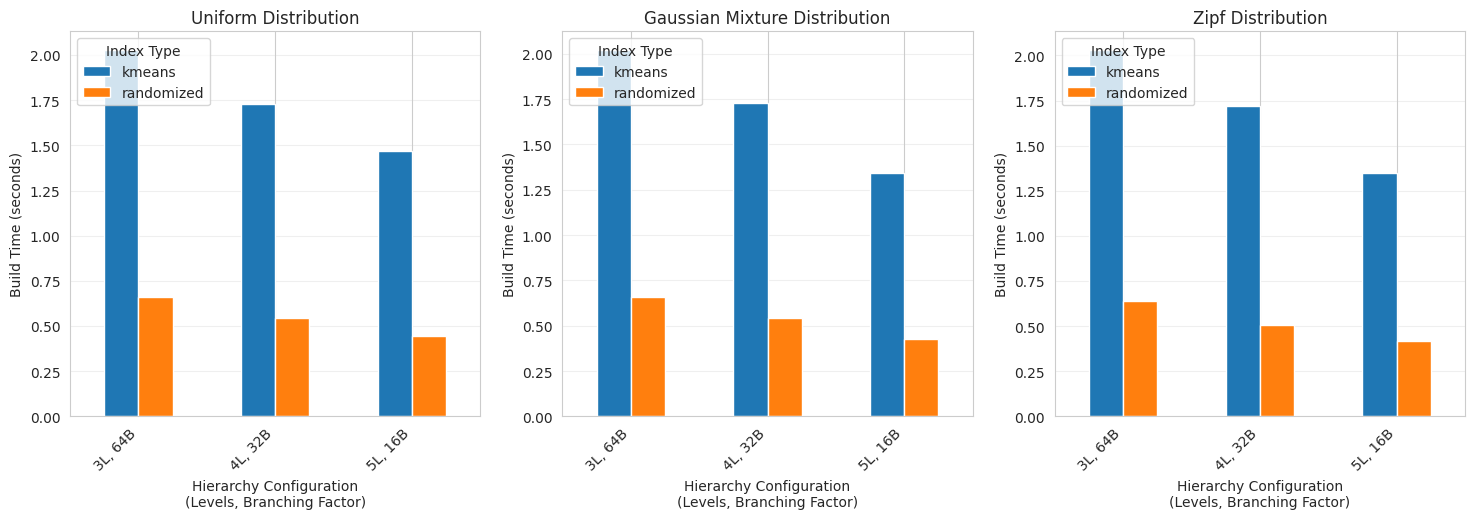

<Figure size 1200x600 with 0 Axes>

In [63]:
# Extract build time data
build_data = []
for r in results:
    build_data.append({
        'Distribution': r['configuration']['data_dist'],
        'Index Type': r['configuration']['index_type'],
        'Levels': r['configuration']['num_levels'],
        'Branch Factor': r['configuration']['branching_factor'],
        'Build Time (s)': r['index_stats']['build_time_sec'],
        'Total Clusters': r['index_stats']['total_clusters'],
        'Memory (MB)': r['index_stats']['memory_mb']
    })

df_build = pd.DataFrame(build_data)

# Plot build times
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    df_dist = df_build[df_build['Distribution'] == dist]
    
    pivot = df_dist.pivot_table(
        values='Build Time (s)',
        index=['Levels', 'Branch Factor'],
        columns='Index Type'
    )
    
    pivot.plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'{dist.replace("_", " ").title()} Distribution')
    axes[idx].set_ylabel('Build Time (seconds)')
    axes[idx].set_xlabel('Hierarchy Configuration\n(Levels, Branching Factor)')
    axes[idx].legend(title='Index Type', loc='upper left')
    axes[idx].grid(axis='y', alpha=0.3)
    # Improve tick labels
    tick_labels = [f'{int(lv)}L, {int(bf)}B' for lv, bf in pivot.index]
    axes[idx].set_xticklabels(tick_labels, rotation=45, ha='right')

plt.show()
plt.tight_layout()

## Search Time vs Brute-Force Comparison

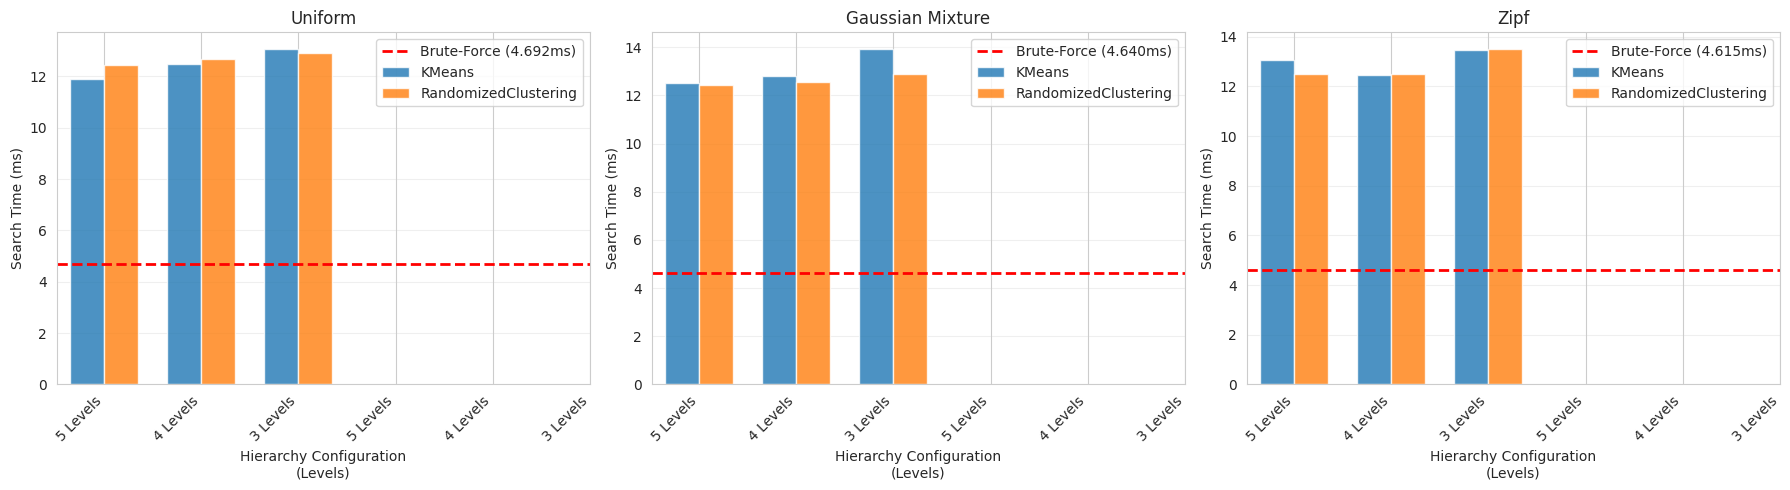

In [64]:
# Extract search time data (using first threshold)
search_data = []
for r in results:
    if r['search_results']['threshold_results']:
        search_stat = r['search_results']['threshold_results'][0]
        bf_stat = r['bruteforce_results']['threshold_results'][0]
        
        search_data.append({
            'Distribution': r['configuration']['data_dist'],
            'Index Type': r['configuration']['index_type'],
            'Levels': r['configuration']['num_levels'],
            'Search Time (ms)': search_stat['avg_search_time_ms'],
            'Brute-Force Time (ms)': bf_stat['avg_search_time_ms'],
            'Recall': search_stat['avg_recall'],
            'Precision': search_stat['avg_precision']
        })

df_search = pd.DataFrame(search_data)

# Calculate speedup (or slowdown)
df_search['Speedup'] = df_search['Brute-Force Time (ms)'] / df_search['Search Time (ms)']

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    df_dist = df_search[df_search['Distribution'] == dist]
    
    x = np.arange(len(df_dist))
    width = 0.35
    
    kmeans_data = df_dist[df_dist['Index Type'] == 'kmeans']
    rc_data = df_dist[df_dist['Index Type'] == 'randomized']
    
    axes[idx].bar(x[:len(kmeans_data)] - width/2, kmeans_data['Search Time (ms)'], 
                   width, label='KMeans', alpha=0.8)
    axes[idx].bar(x[:len(rc_data)] + width/2, rc_data['Search Time (ms)'], 
                   width, label='RandomizedClustering', alpha=0.8)
    
    # Add brute-force baseline
    if len(kmeans_data) > 0:
        bf_time = kmeans_data['Brute-Force Time (ms)'].iloc[0]
        axes[idx].axhline(y=bf_time, color='red', linestyle='--', 
                          label=f'Brute-Force ({bf_time:.3f}ms)', linewidth=2)
    
    axes[idx].set_title(f'{dist.replace("_", " ").title()}')
    axes[idx].set_ylabel('Search Time (ms)')
    axes[idx].set_xlabel('Hierarchy Configuration\n(Levels)')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([f'{r["Levels"]} Levels' for _, r in df_dist.iterrows()], rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Recall and Precision Analysis

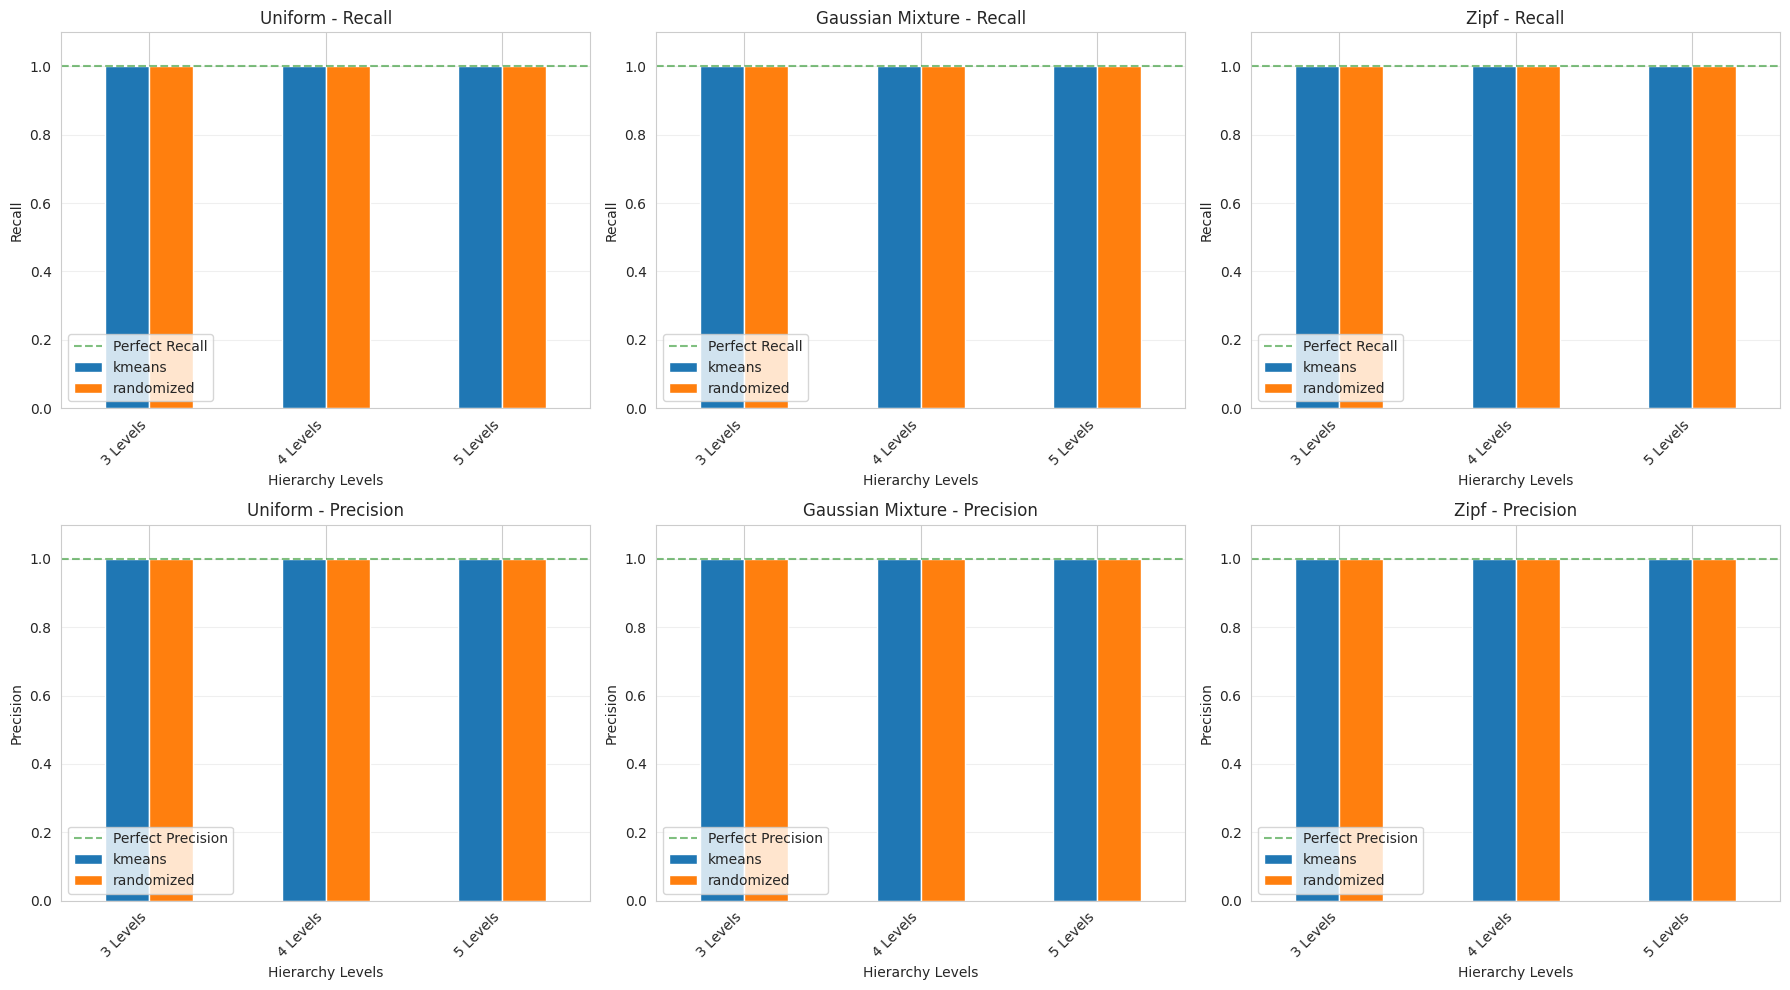

In [65]:
# Plot recall and precision
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    df_dist = df_search[df_search['Distribution'] == dist]
    
    # Recall plot
    pivot_recall = df_dist.pivot_table(
        values='Recall',
        index='Levels',
        columns='Index Type'
    )
    pivot_recall.plot(kind='bar', ax=axes[0, idx])
    axes[0, idx].set_title(f'{dist.replace("_", " ").title()} - Recall')
    axes[0, idx].set_ylabel('Recall')
    axes[0, idx].set_xlabel('Hierarchy Levels')
    axes[0, idx].set_ylim([0, 1.1])
    axes[0, idx].axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Recall')
    axes[0, idx].legend()
    axes[0, idx].grid(axis='y', alpha=0.3)
    axes[0, idx].set_xticklabels([f'{int(x)} Levels' for x in pivot_recall.index], rotation=45, ha='right')
    
    # Precision plot
    pivot_precision = df_dist.pivot_table(
        values='Precision',
        index='Levels',
        columns='Index Type'
    )
    pivot_precision.plot(kind='bar', ax=axes[1, idx])
    axes[1, idx].set_title(f'{dist.replace("_", " ").title()} - Precision')
    axes[1, idx].set_ylabel('Precision')
    axes[1, idx].set_xlabel('Hierarchy Levels')
    axes[1, idx].set_ylim([0, 1.1])
    axes[1, idx].axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Precision')
    axes[1, idx].legend()
    axes[1, idx].grid(axis='y', alpha=0.3)
    axes[1, idx].set_xticklabels([f'{int(x)} Levels' for x in pivot_precision.index], rotation=45, ha='right')
    axes[1, idx].set_xticklabels([f'{int(x)} Levels' for x in pivot_precision.index], rotation=45, ha='right')



plt.tight_layout()
plt.show()

## Memory Usage Comparison

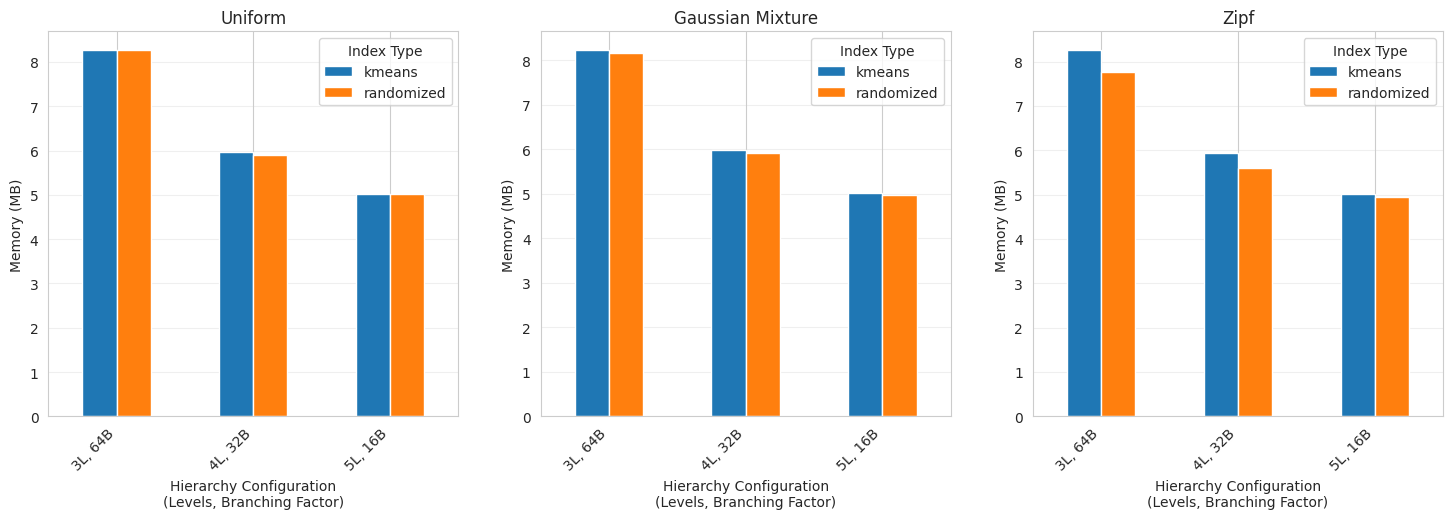

<Figure size 1200x600 with 0 Axes>

In [66]:
# Plot memory usage
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    df_dist = df_build[df_build['Distribution'] == dist]
    
    pivot = df_dist.pivot_table(
        values='Memory (MB)',
        index=['Levels', 'Branch Factor'],
        columns='Index Type'
    )
    
    pivot.plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'{dist.replace("_", " ").title()}')
    axes[idx].set_ylabel('Memory (MB)')
    axes[idx].set_xlabel('Hierarchy Configuration\n(Levels, Branching Factor)')
    axes[idx].legend(title='Index Type')
    axes[idx].grid(axis='y', alpha=0.3)
    # Improve tick labels
    tick_labels = [f'{int(lv)}L, {int(bf)}B' for lv, bf in pivot.index]
    axes[idx].set_xticklabels(tick_labels, rotation=45, ha='right')

plt.show()
plt.tight_layout()

## Cluster Count Analysis

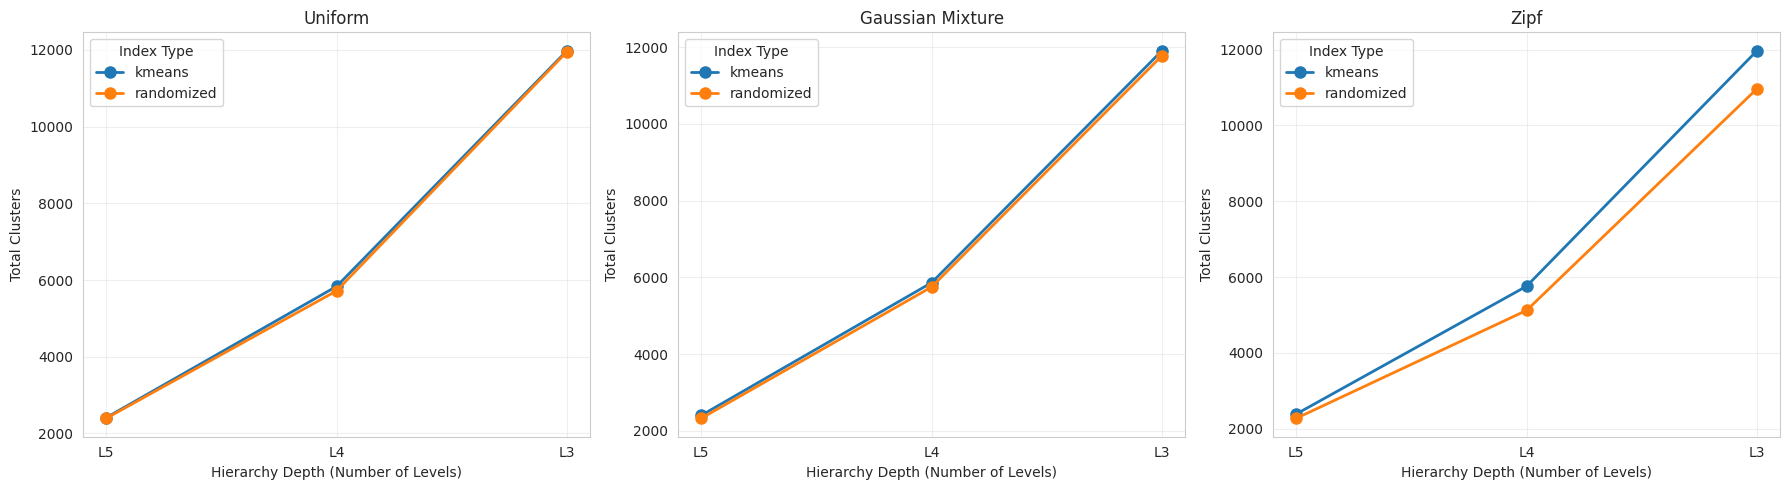


Detailed Cluster Counts per Level:

KMEANS | uniform | Levels=5, Branch=16
  Level 0: 16 clusters, avg_radius=13.867
  Level 1: 256 clusters, avg_radius=12.985
  Level 2: 496 clusters, avg_radius=12.534
  Level 3: 731 clusters, avg_radius=11.540
  Level 4: 913 clusters, avg_radius=10.745

KMEANS | uniform | Levels=4, Branch=32
  Level 0: 32 clusters, avg_radius=13.502
  Level 1: 994 clusters, avg_radius=12.100
  Level 2: 1986 clusters, avg_radius=10.991
  Level 3: 2824 clusters, avg_radius=9.675

KMEANS | uniform | Levels=3, Branch=64
  Level 0: 64 clusters, avg_radius=13.243
  Level 1: 4020 clusters, avg_radius=10.069
  Level 2: 7897 clusters, avg_radius=8.478


In [67]:
# Analyze cluster distribution across levels
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    df_dist = df_build[df_build['Distribution'] == dist]
    
    ax = axes[idx]
    
    # Plot total clusters
    for index_type in ['kmeans', 'randomized']:
        df_type = df_dist[df_dist['Index Type'] == index_type]
        x = [f"L{row['Levels']}" for _, row in df_type.iterrows()]
        y = df_type['Total Clusters'].values
        ax.plot(x, y, marker='o', label=index_type, linewidth=2, markersize=8)
    
    ax.set_title(f'{dist.replace("_", " ").title()}')
    ax.set_ylabel('Total Clusters')
    ax.set_xlabel('Hierarchy Depth (Number of Levels)')
    ax.legend(title='Index Type', loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Show detailed cluster counts per level
print("\nDetailed Cluster Counts per Level:")
print("="*80)
for r in results[:3]:  # Show first 3 as examples
    config = r['configuration']
    print(f"\n{config['index_type'].upper()} | {config['data_dist']} | "
          f"Levels={config['num_levels']}, Branch={config['branching_factor']}")
    for level_stat in r['index_stats']['levels']:
        print(f"  Level {level_stat['level_idx']}: {level_stat['num_clusters']} clusters, "
              f"avg_radius={level_stat['avg_radius']:.3f}")

## Summary Table

In [68]:
# Create comprehensive summary table
summary_data = []
for r in results:
    config = r['configuration']
    stats = r['index_stats']
    search = r['search_results']['threshold_results'][0] if r['search_results']['threshold_results'] else {}
    bf = r['bruteforce_results']['threshold_results'][0] if r['bruteforce_results']['threshold_results'] else {}
    
    summary_data.append({
        'Distribution': config['data_dist'],
        'Index': config['index_type'],
        'Levels': config['num_levels'],
        'Branch': config['branching_factor'],
        'Build (s)': f"{stats['build_time_sec']:.3f}",
        'Clusters': stats['total_clusters'],
        'Memory (MB)': f"{stats['memory_mb']:.2f}",
        'Search (ms)': f"{search.get('avg_search_time_ms', 0):.3f}",
        'BF (ms)': f"{bf.get('avg_search_time_ms', 0):.3f}",
        'Recall': f"{search.get('avg_recall', 0):.3f}",
        'Precision': f"{search.get('avg_precision', 0):.3f}"
    })

df_summary = pd.DataFrame(summary_data)

# Display grouped by distribution
for dist in ['uniform', 'gaussian_mixture', 'zipf']:
    print(f"\n{dist.upper().replace('_', ' ')} DISTRIBUTION")
    print("="*100)
    dist_df = df_summary[df_summary['Distribution'] == dist].drop('Distribution', axis=1)
    print(dist_df.to_string(index=False))
    print()


UNIFORM DISTRIBUTION
     Index  Levels  Branch Build (s)  Clusters Memory (MB) Search (ms) BF (ms) Recall Precision
    kmeans       5      16     1.469      2412        5.02      11.912   4.692  1.000     1.000
    kmeans       4      32     1.728      5836        5.97      12.494   4.616  1.000     1.000
    kmeans       3      64     2.029     11981        8.28      13.065   4.616  1.000     1.000
randomized       5      16     0.442      2395        5.01      12.431   4.656  1.000     1.000
randomized       4      32     0.543      5720        5.91      12.680   4.446  1.000     1.000
randomized       3      64     0.659     11956        8.26      12.921   4.619  1.000     1.000


GAUSSIAN MIXTURE DISTRIBUTION
     Index  Levels  Branch Build (s)  Clusters Memory (MB) Search (ms) BF (ms) Recall Precision
    kmeans       5      16     1.345      2399        5.01      12.529   4.640  1.000     1.000
    kmeans       4      32     1.727      5859        5.98      12.787   4.737  1.

## Performance by Threshold Quantile

Now let's analyze performance separately for each threshold quantile to see how search behavior changes with different selectivity levels.

In [69]:
# Extract data for all thresholds
all_thresholds_data = []

for r in results:
    config = r['configuration']
    
    # Process each threshold result
    for thresh_idx, thresh_result in enumerate(r['search_results']['threshold_results']):
        bf_result = r['bruteforce_results']['threshold_results'][thresh_idx]
        
        all_thresholds_data.append({
            'Distribution': config['data_dist'],
            'Index Type': config['index_type'],
            'Levels': config['num_levels'],
            'Threshold': thresh_result['threshold'],
            'Threshold_Idx': thresh_idx,
            'Search Time (ms)': thresh_result['avg_search_time_ms'],
            'BF Time (ms)': bf_result['avg_search_time_ms'],
            'Num Results': thresh_result['avg_num_results'],
            'Recall': thresh_result['avg_recall'],
            'Precision': thresh_result['avg_precision'],
            'Speedup': bf_result['avg_search_time_ms'] / thresh_result['avg_search_time_ms']
        })

df_all_thresholds = pd.DataFrame(all_thresholds_data)

# Show what thresholds we have
print("Threshold quantiles tested:")
sample = df_all_thresholds[df_all_thresholds['Distribution'] == 'uniform'].groupby('Threshold_Idx')['Threshold'].first()
for idx, thresh in sample.items():
    print(f"  Quantile {idx}: ~{thresh:.2f}")
print(f"\nTotal data points: {len(df_all_thresholds)}")

Threshold quantiles tested:
  Quantile 0: ~-42.76
  Quantile 1: ~-35.37
  Quantile 2: ~-26.52
  Quantile 3: ~-23.42
  Quantile 4: ~-19.93
  Quantile 5: ~-15.96
  Quantile 6: ~-11.30
  Quantile 7: ~-5.31

Total data points: 144


### Search Time by Quantile

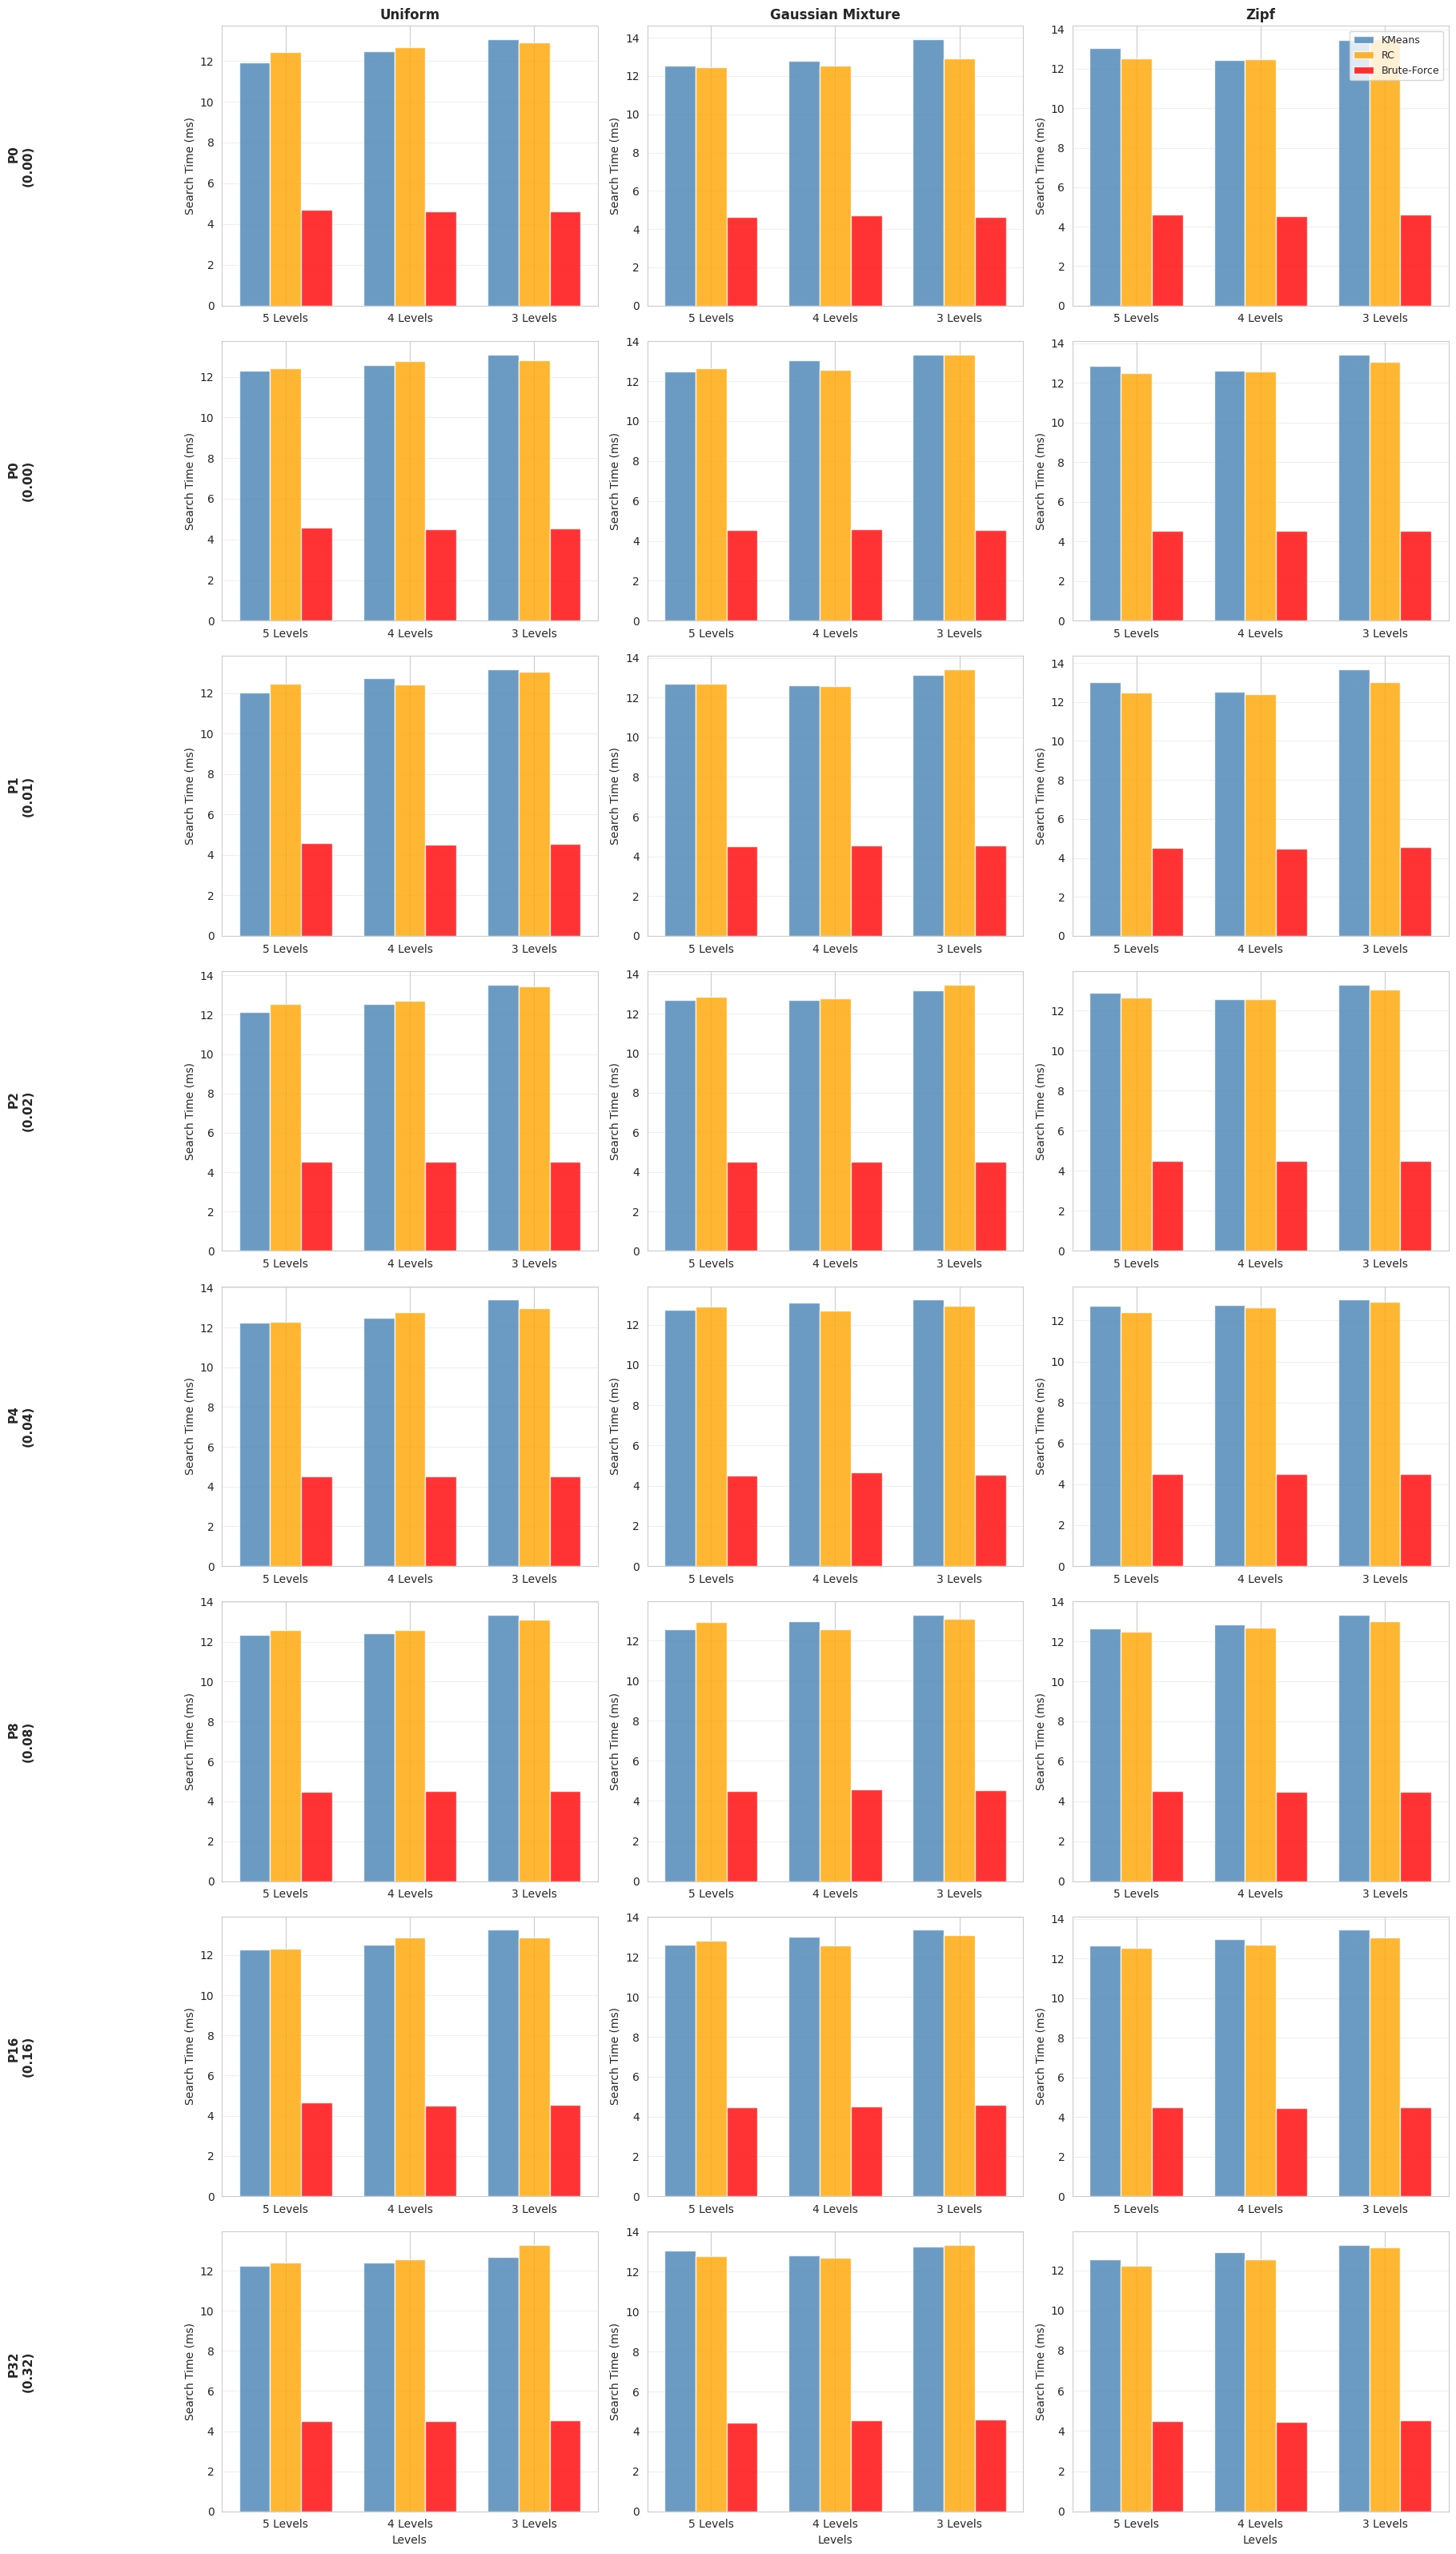

In [70]:
# Plot search time for each quantile across distributions
num_quantiles = len(PERCENTILES)

# Generate quantile labels from the PERCENTILES constant
quantile_labels = [f'P{int(p*100)}\n({p:.2f})' for p in PERCENTILES]

fig, axes = plt.subplots(num_quantiles, 3, figsize=(18, 4*num_quantiles))

for q_idx in range(num_quantiles):
    for dist_idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
        ax = axes[q_idx, dist_idx]
        
        # Filter data
        df_filtered = df_all_thresholds[
            (df_all_thresholds['Distribution'] == dist) & 
            (df_all_thresholds['Threshold_Idx'] == q_idx)
        ]
        
        # Group by index type and levels
        kmeans_df = df_filtered[df_filtered['Index Type'] == 'kmeans']
        rc_df = df_filtered[df_filtered['Index Type'] == 'randomized']
        
        x_pos = np.arange(len(kmeans_df))
        width = 0.25
        
        # Plot bars
        ax.bar(x_pos - width, kmeans_df['Search Time (ms)'], width, 
               label='KMeans', alpha=0.8, color='steelblue')
        ax.bar(x_pos, rc_df['Search Time (ms)'], width,
               label='RC', alpha=0.8, color='orange')
        ax.bar(x_pos + width, kmeans_df['BF Time (ms)'], width,
               label='Brute-Force', alpha=0.8, color='red')
        
        # Formatting
        if q_idx == 0:
            ax.set_title(f'{dist.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        
        ax.set_ylabel('Search Time (ms)', fontsize=10)
        ax.set_xlabel('Levels' if q_idx == num_quantiles - 1 else '', fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels([f'{l} Levels' for l in kmeans_df['Levels']], rotation=0)
        
        if dist_idx == 0:
            ax.text(-0.5, 0.5, quantile_labels[q_idx], 
                   transform=ax.transAxes, fontsize=11, fontweight='bold',
                   rotation=90, va='center', ha='right')
        
        if q_idx == 0 and dist_idx == 2:
            ax.legend(loc='upper right', fontsize=9)
        
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Result Set Size by Quantile

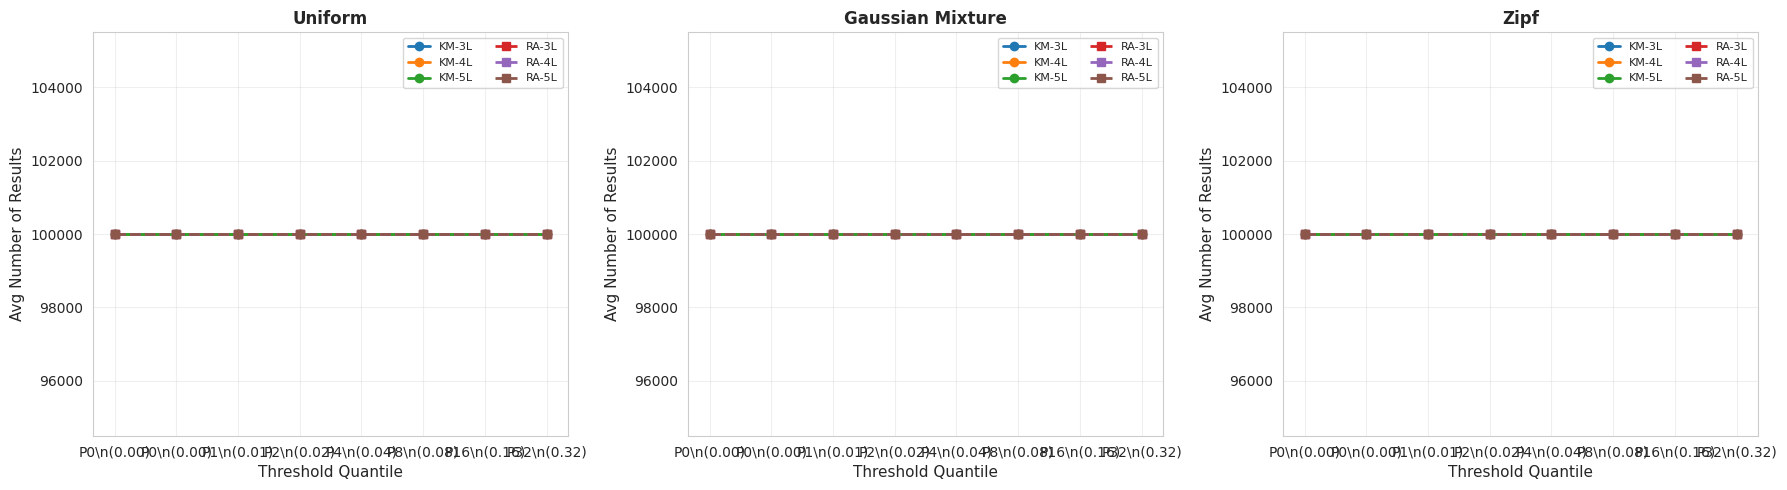

In [71]:
# Plot number of results returned for each quantile
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for dist_idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    ax = axes[dist_idx]
    
    df_dist = df_all_thresholds[df_all_thresholds['Distribution'] == dist]
    
    # Plot lines for each index type and level configuration
    for index_type in ['kmeans', 'randomized']:
        for level in sorted(df_dist['Levels'].unique()):
            df_subset = df_dist[
                (df_dist['Index Type'] == index_type) & 
                (df_dist['Levels'] == level)
            ]
            
            if len(df_subset) > 0:
                marker = 'o' if index_type == 'kmeans' else 's'
                linestyle = '-' if index_type == 'kmeans' else '--'
                label = f'{index_type[:2].upper()}-{level}L'
                
                ax.plot(df_subset['Threshold_Idx'], df_subset['Num Results'], 
                       marker=marker, linestyle=linestyle, label=label, linewidth=2, markersize=6)
    
    ax.set_title(f'{dist.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Threshold Quantile', fontsize=11)
    ax.set_ylabel('Avg Number of Results', fontsize=11)
    ax.set_xticks(range(num_quantiles))
    ax.set_xticklabels([ql.replace('\n', '\\n') for ql in quantile_labels])
    ax.legend(ncol=2, fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Recall and Precision by Quantile

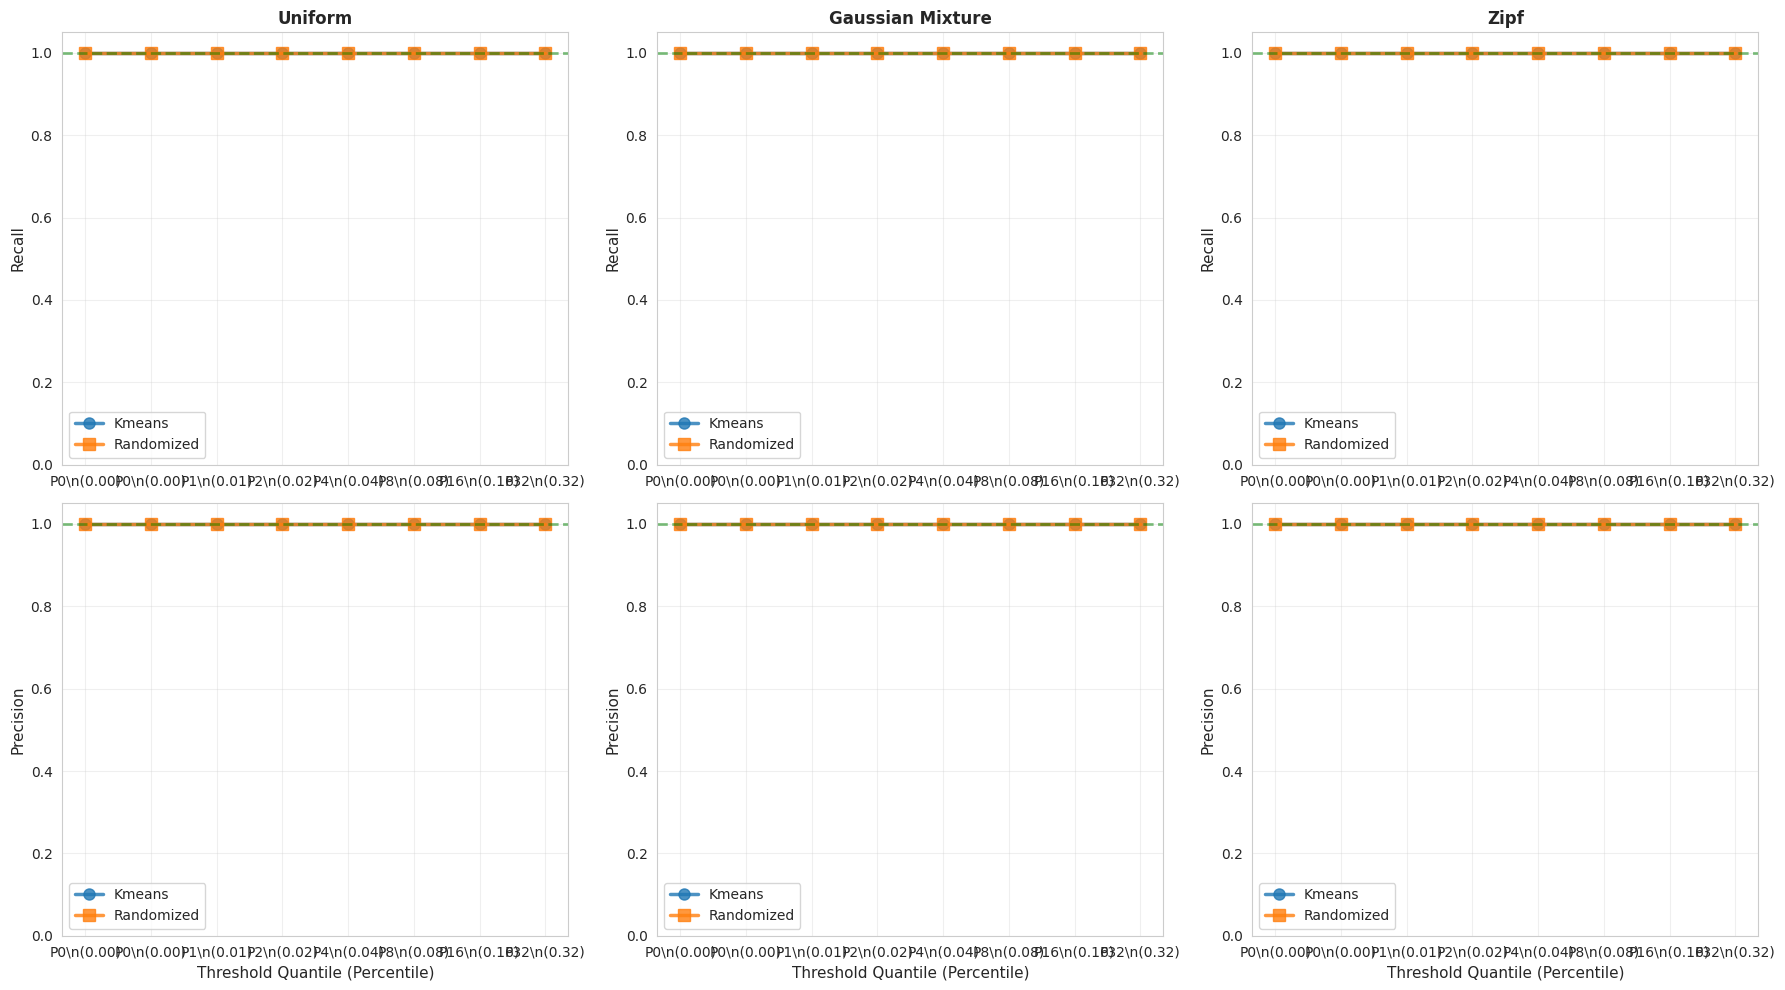

In [72]:
# Plot recall and precision trends across quantiles
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for dist_idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    # Recall plot
    ax_recall = axes[0, dist_idx]
    df_dist = df_all_thresholds[df_all_thresholds['Distribution'] == dist]
    
    for index_type in ['kmeans', 'randomized']:
        df_type = df_dist[df_dist['Index Type'] == index_type]
        # Average across all level configurations
        recall_by_quantile = df_type.groupby('Threshold_Idx')['Recall'].mean()
        
        marker = 'o' if index_type == 'kmeans' else 's'
        ax_recall.plot(recall_by_quantile.index, recall_by_quantile.values, 
                      marker=marker, linewidth=2.5, markersize=8, 
                      label=index_type.capitalize(), alpha=0.8)
    
    ax_recall.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, linewidth=2)
    ax_recall.set_title(f'{dist.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax_recall.set_ylabel('Recall', fontsize=11)
    ax_recall.set_ylim([0, 1.05])
    ax_recall.set_xticks(range(num_quantiles))
    ax_recall.set_xticklabels([ql.replace('\n', '\\n') for ql in quantile_labels])
    ax_recall.legend()
    ax_recall.grid(alpha=0.3)
    
    # Precision plot
    ax_precision = axes[1, dist_idx]
    
    for index_type in ['kmeans', 'randomized']:
        df_type = df_dist[df_dist['Index Type'] == index_type]
        precision_by_quantile = df_type.groupby('Threshold_Idx')['Precision'].mean()
        
        marker = 'o' if index_type == 'kmeans' else 's'
        ax_precision.plot(precision_by_quantile.index, precision_by_quantile.values, 
                         marker=marker, linewidth=2.5, markersize=8, 
                         label=index_type.capitalize(), alpha=0.8)
    
    ax_precision.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, linewidth=2)
    ax_precision.set_ylabel('Precision', fontsize=11)
    ax_precision.set_xlabel('Threshold Quantile (Percentile)', fontsize=11)
    ax_precision.set_ylim([0, 1.05])
    ax_precision.set_xticks(range(num_quantiles))
    ax_precision.set_xticklabels([ql.replace('\n', '\\n') for ql in quantile_labels])
    ax_precision.legend()
    ax_precision.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Speedup vs Brute-Force by Quantile

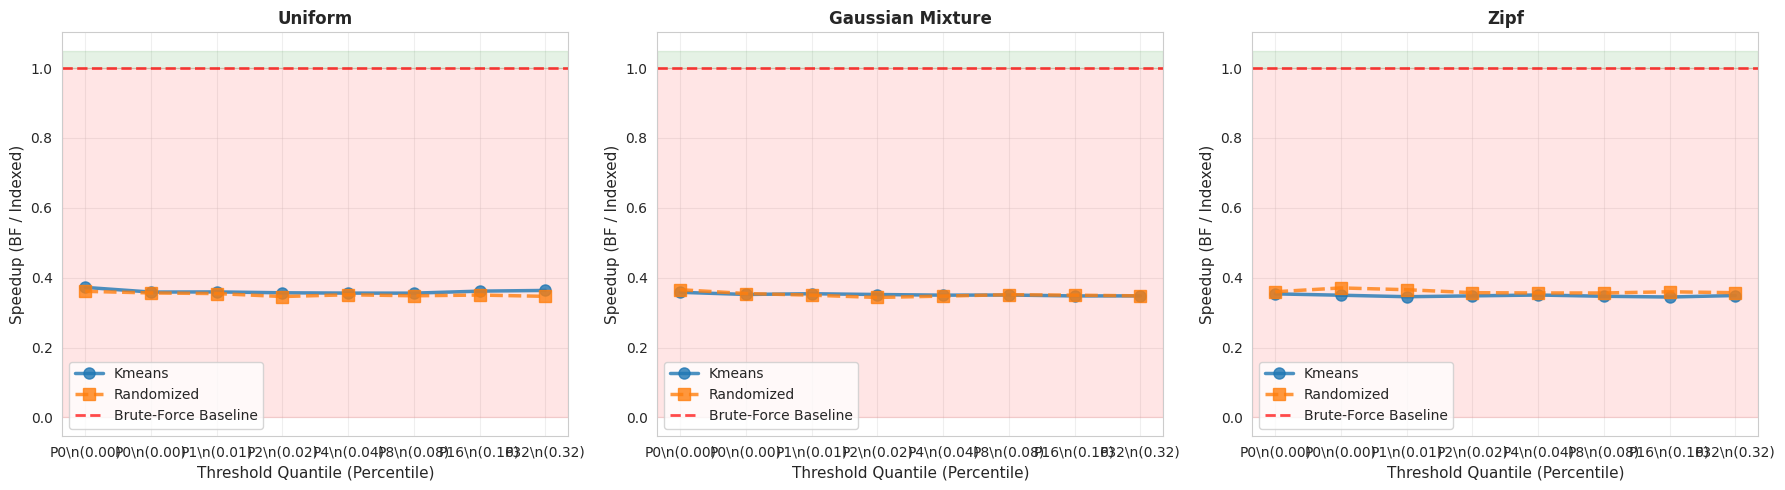


SPEEDUP STATISTICS BY QUANTILE

P0
(0.00):
  Kmeans         : Speedup=0.361x, AvgResults=100000.0, Recall=1.000
  Randomized     : Speedup=0.362x, AvgResults=100000.0, Recall=1.000

P0
(0.00):
  Kmeans         : Speedup=0.354x, AvgResults=100000.0, Recall=1.000
  Randomized     : Speedup=0.361x, AvgResults=100000.0, Recall=1.000

P1
(0.01):
  Kmeans         : Speedup=0.353x, AvgResults=100000.0, Recall=1.000
  Randomized     : Speedup=0.357x, AvgResults=100000.0, Recall=1.000

P2
(0.02):
  Kmeans         : Speedup=0.352x, AvgResults=100000.0, Recall=1.000
  Randomized     : Speedup=0.349x, AvgResults=100000.0, Recall=1.000

P4
(0.04):
  Kmeans         : Speedup=0.352x, AvgResults=100000.0, Recall=1.000
  Randomized     : Speedup=0.352x, AvgResults=100000.0, Recall=1.000

P8
(0.08):
  Kmeans         : Speedup=0.351x, AvgResults=100000.0, Recall=1.000
  Randomized     : Speedup=0.352x, AvgResults=100000.0, Recall=1.000

P16
(0.16):
  Kmeans         : Speedup=0.351x, AvgResults=100000.0,

In [73]:
# Heatmap showing speedup for each quantile
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for dist_idx, dist in enumerate(['uniform', 'gaussian_mixture', 'zipf']):
    ax = axes[dist_idx]
    
    df_dist = df_all_thresholds[df_all_thresholds['Distribution'] == dist]
    
    for index_type in ['kmeans', 'randomized']:
        df_type = df_dist[df_dist['Index Type'] == index_type]
        speedup_by_quantile = df_type.groupby('Threshold_Idx')['Speedup'].mean()
        
        marker = 'o' if index_type == 'kmeans' else 's'
        linestyle = '-' if index_type == 'kmeans' else '--'
        
        ax.plot(speedup_by_quantile.index, speedup_by_quantile.values, 
               marker=marker, linestyle=linestyle, linewidth=2.5, markersize=8, 
               label=index_type.capitalize(), alpha=0.8)
    
    # Add baseline
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, 
              label='Brute-Force Baseline', alpha=0.7)
    
    ax.set_title(f'{dist.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Speedup (BF / Indexed)', fontsize=11)
    ax.set_xlabel('Threshold Quantile (Percentile)', fontsize=11)
    ax.set_xticks(range(num_quantiles))
    ax.set_xticklabels([ql.replace('\n', '\\n') for ql in quantile_labels])
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Add shading for speedup vs slowdown regions
    ax.axhspan(0, 1, alpha=0.1, color='red', label='_nolegend_')
    ax.axhspan(1, ax.get_ylim()[1], alpha=0.1, color='green', label='_nolegend_')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("SPEEDUP STATISTICS BY QUANTILE")
print("="*80)
for q_idx in range(num_quantiles):
    print(f"\n{quantile_labels[q_idx]}:")
    df_q = df_all_thresholds[df_all_thresholds['Threshold_Idx'] == q_idx]
    
    for index_type in ['kmeans', 'randomized']:
        df_type = df_q[df_q['Index Type'] == index_type]
        avg_speedup = df_type['Speedup'].mean()
        avg_results = df_type['Num Results'].mean()
        avg_recall = df_type['Recall'].mean()
        
        print(f"  {index_type.capitalize():15s}: Speedup={avg_speedup:.3f}x, "
              f"AvgResults={avg_results:.1f}, Recall={avg_recall:.3f}")

### Detailed Quantile Performance Table

In [74]:
# Create detailed table for each distribution showing all quantiles
for dist in ['uniform', 'gaussian_mixture', 'zipf']:
    print(f"\n{'='*100}")
    print(f"{dist.upper().replace('_', ' ')} DISTRIBUTION - PERFORMANCE BY QUANTILE")
    print('='*100)
    
    df_dist = df_all_thresholds[df_all_thresholds['Distribution'] == dist]
    
    # Prepare summary table
    table_data = []
    for q_idx in range(num_quantiles):
        df_q = df_dist[df_dist['Threshold_Idx'] == q_idx]
        
        for index_type in ['kmeans', 'randomized']:
            df_type = df_q[df_q['Index Type'] == index_type]
            
            for level in sorted(df_type['Levels'].unique()):
                df_config = df_type[df_type['Levels'] == level]
                
                if len(df_config) > 0:
                    row = df_config.iloc[0]
                    table_data.append({
                        'Quantile': quantile_labels[q_idx],
                        'Index': index_type[:2].upper(),
                        'L': level,
                        'Threshold': f"{row['Threshold']:.2f}",
                        'Search(ms)': f"{row['Search Time (ms)']:.3f}",
                        'BF(ms)': f"{row['BF Time (ms)']:.3f}",
                        'Speedup': f"{row['Speedup']:.2f}x",
                        'Results': f"{row['Num Results']:.0f}",
                        'Recall': f"{row['Recall']:.3f}",
                        'Precision': f"{row['Precision']:.3f}"
                    })
    
    df_table = pd.DataFrame(table_data)
    print(df_table.to_string(index=False))
    print()


UNIFORM DISTRIBUTION - PERFORMANCE BY QUANTILE
   Quantile Index  L Threshold Search(ms) BF(ms) Speedup Results Recall Precision
 P0\n(0.00)    KM  3    -42.76     13.065  4.616   0.35x  100000  1.000     1.000
 P0\n(0.00)    KM  4    -42.76     12.494  4.616   0.37x  100000  1.000     1.000
 P0\n(0.00)    KM  5    -42.76     11.912  4.692   0.39x  100000  1.000     1.000
 P0\n(0.00)    RA  3    -42.76     12.921  4.619   0.36x  100000  1.000     1.000
 P0\n(0.00)    RA  4    -42.76     12.680  4.446   0.35x  100000  1.000     1.000
 P0\n(0.00)    RA  5    -42.76     12.431  4.656   0.37x  100000  1.000     1.000
 P0\n(0.00)    KM  3    -35.37     13.105  4.545   0.35x  100000  1.000     1.000
 P0\n(0.00)    KM  4    -35.37     12.579  4.501   0.36x  100000  1.000     1.000
 P0\n(0.00)    KM  5    -35.37     12.296  4.573   0.37x  100000  1.000     1.000
 P0\n(0.00)    RA  3    -35.37     12.798  4.659   0.36x  100000  1.000     1.000
 P0\n(0.00)    RA  4    -35.37     12.771  4.342  